In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys

sys.path.append("../")

import torch
from models.vae import VAE
from models.sae import SAE
from vae_interp.controls import FeaturesControls
from dataset import load_nouns_dataset, NpyDataset
import matplotlib.pyplot as plt
from torchvision.transforms import ToPILImage
from utils import make_image_grid

/Users/ericchen/Library/Caches/pypoetry/virtualenvs/swiggle-q2KFjl8n-py3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [36]:
vae = VAE.load_from_dir("../weights/vae")
sae = SAE.load_from_checkpoint("../checkpoints/sae_experiments_longer_warmup/lr=3.0e-04_l1=1.0e-01/config.json",
                               "../checkpoints/sae_experiments_longer_warmup/lr=3.0e-04_l1=1.0e-01/sae.pth")
# path = "../checkpoints/sae_awesome/lr=5.0e-03_l1=1.0e-02"
# path = "../checkpoints/eric/lr=1.0e-03_l1=1.0e-02"
# sae = SAE.load_from_checkpoint(f"{path}/config.json",
                            #    f"{path}/sae.pth")

In [37]:
nouns_dataset = load_nouns_dataset(image_size=64, normalize=True)

In [38]:
features_controls = FeaturesControls(
    sae=sae, vae=vae, latent_shape=(4, 4, 4)
)

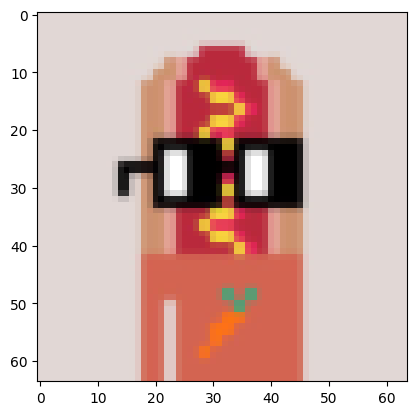

In [39]:
idx = 0
image = nouns_dataset[idx]
original_image = nouns_dataset.dataset[idx]["image"]

plt.imshow((image.permute(1, 2, 0) + 1) * 0.5)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.01380229..1.0109622].


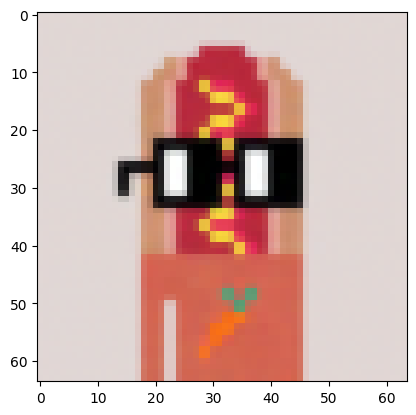

In [40]:
with torch.no_grad():
    recon = vae(image.unsqueeze(0))["recon"]

plt.imshow((recon.squeeze().permute(1, 2, 0) + 1) * 0.5)

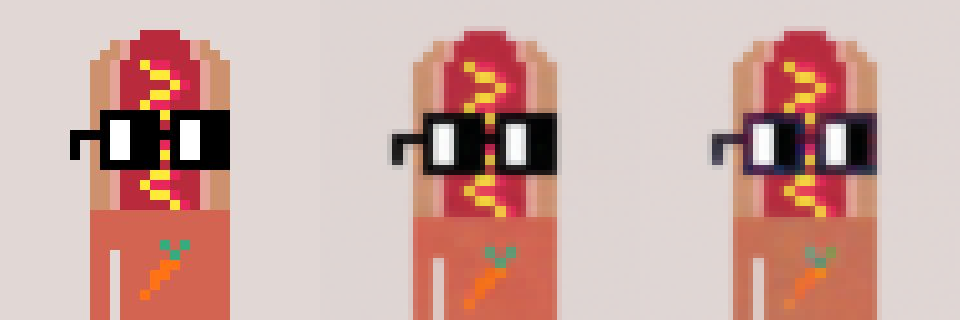

In [41]:
with torch.no_grad():
    recon = vae(image.unsqueeze(0))["recon"]

vae_recon = torch.clamp((recon - recon.min()) / (recon.max() - recon.min()), 0, 1)
vae_recon = ToPILImage()(vae_recon.squeeze())

with torch.no_grad():
    mu, _ = vae.encode(image.unsqueeze(0))
    mu = mu.view(1, -1)
    c = sae.encode(mu)
    sae_recon_latent = sae.decode(c).view(1, 4, 4, 4)
    sae_recon = vae.decode(sae_recon_latent).squeeze()
    
sae_recon = torch.clamp((sae_recon - sae_recon.min()) / (sae_recon.max() - sae_recon.min()), 0, 1)
sae_recon = ToPILImage()(sae_recon)

make_image_grid([original_image, vae_recon.resize((330, 330), 0), sae_recon.resize((330, 330), 0)], 1, 3)

In [42]:
features = features_controls.get_features(image)
features

{39: 0.26976776123046875,
 56: 0.24839861690998077,
 64: 0.04139995574951172,
 70: 0.07752440124750137,
 105: 0.01854688674211502,
 114: 0.03798960894346237,
 129: 0.4538552165031433,
 208: 0.16622978448867798,
 224: 0.014123231172561646,
 231: 0.07771126925945282,
 271: 0.056796468794345856,
 297: 0.02220197394490242,
 299: 0.06573542207479477,
 301: 0.027210712432861328,
 307: 0.08554966747760773,
 327: 3.3077220916748047,
 361: 0.2625252902507782,
 367: 0.15636390447616577,
 416: 0.027470462024211884,
 424: 0.010315757244825363,
 428: 0.359539270401001,
 467: 0.01977502554655075}

{39: 0.26976776123046875, 56: 0.24839861690998077, 64: 0.04139995574951172, 70: 0.07752440124750137, 105: 0.01854688674211502, 114: 0.03798960894346237, 129: 0.4538552165031433, 208: 0.16622978448867798, 224: 0.014123231172561646, 231: 0.07771126925945282, 271: 0.056796468794345856, 297: 0.02220197394490242, 299: 0.06573542207479477, 301: 0.027210712432861328, 307: 0.08554966747760773, 327: 3.3077220916748047, 361: 0.2625252902507782, 367: 0.15636390447616577, 416: 0.027470462024211884, 424: 0.010315757244825363, 428: 0.359539270401001, 467: 0.01977502554655075}


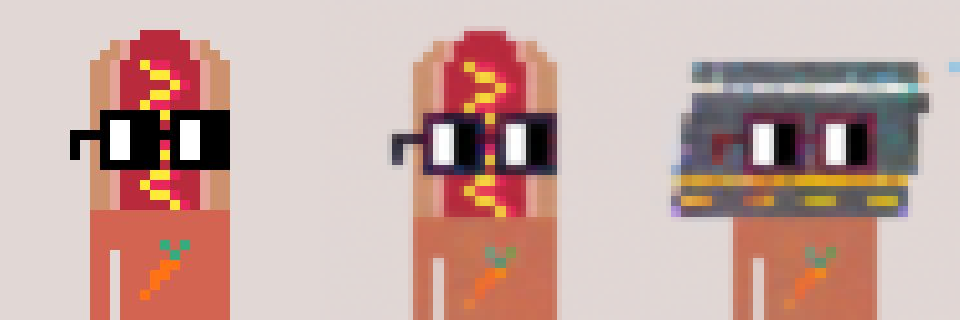

In [58]:

# features_ = {x["feature_id"]: x["activation"] for x in features}
# print(features_)
new_features ={
    # 1007: 0
    **features
}

print(new_features)

new_features[327] = 0
new_features[300] = 4
# new_features[428] = 0
# new_features[361] = 0
# new_features[245] = 1
# new_features[256] = 0

# for k in new_features.keys():
#     new_features[k] = 0
# new_features[1019] = 0
# new_features[245] = 2
# new_features[161] = 0.5

import torch
modified_image = features_controls.modify_features(image, new_features)
# modified_image = (modified_image - modified_image.min()) / (modified_image.max() - modified_image.min())
modified_image = torch.clamp((modified_image + 1) * 0.5, 0, 1)  
# modified_image = modified_image.permute(1, 2, 0)

from utils import make_image_grid
from torchvision.transforms import ToPILImage
from PIL import Image

sae_recon = features_controls.modify_features(image, features)
sae_recon = torch.clamp((sae_recon + 1) * 0.5, 0, 1)
sae_recon = ToPILImage()(sae_recon).resize((330, 330), 0)

modified_image = ToPILImage()(modified_image).resize((330, 330), 0)

make_image_grid([
    original_image,
    sae_recon,
    modified_image
], rows=1, cols=3)